In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# 데이터 불러오기
data = pd.read_csv("C:/Users/LIM/OneDrive - gachon.ac.kr/바탕 화면/study/인공지능개론/BP_data.csv")
data.head()

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0


In [8]:
# 데이터 확인
print(data.columns.tolist())  #컬럼명 확인
data.dtypes            #데이터 타입 확인

['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin', 'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy', 'Smoking', 'Physical_activity', 'salt_content_in_the_diet', 'alcohol_consumption_per_day', 'Level_of_Stress', 'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders']


Patient_Number                     int64
Blood_Pressure_Abnormality         int64
Level_of_Hemoglobin              float64
Genetic_Pedigree_Coefficient     float64
Age                                int64
BMI                                int64
Sex                                int64
Pregnancy                        float64
Smoking                            int64
Physical_activity                  int64
salt_content_in_the_diet           int64
alcohol_consumption_per_day      float64
Level_of_Stress                    int64
Chronic_kidney_disease             int64
Adrenal_and_thyroid_disorders      int64
dtype: object

In [10]:
# 결측치 제거
data.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [14]:
# Genetic_Pedigree_Coefficient 결측치 0으로 대체
data['Genetic_Pedigree_Coefficient'] = data['Genetic_Pedigree_Coefficient'].fillna(0)

In [18]:
# Pregnancy 결측치 0으로 대체
data['Pregnancy'] = data['Pregnancy'].fillna(0)

In [20]:
# alcohol_consumption_per_day 결측치 0으로 대체
data['alcohol_consumption_per_day'] = data['alcohol_consumption_per_day'].fillna(0)

In [22]:
# 결측치 다시 확인
print(data.isnull().sum())  

Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Pregnancy                        0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64


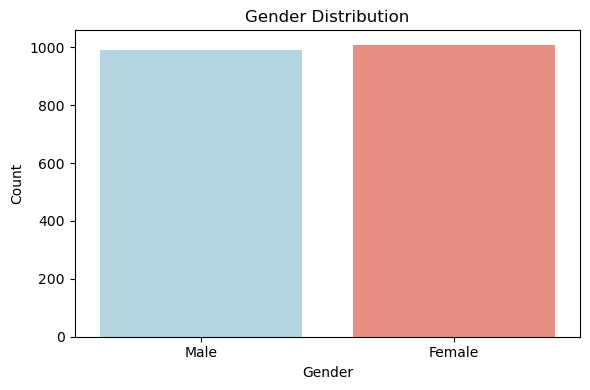

In [28]:
# If 'Sex' column is numeric (0 for Female, 1 for Male), map to string labels
# 남녀 성비 확인
data['Sex_label'] = data['Sex'].map({0: 'Female', 1: 'Male'})

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Sex_label', hue='Sex_label', palette=['lightblue', 'salmon'], legend=False)

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

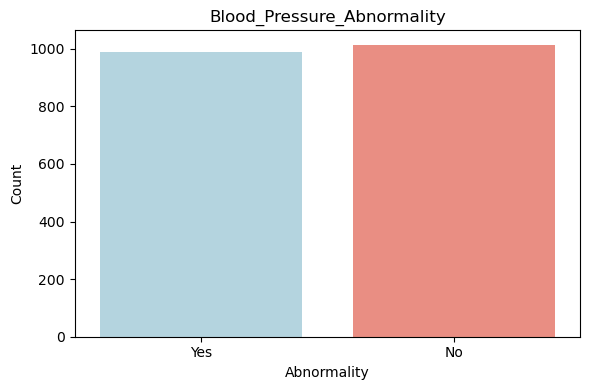

In [32]:
# If 'Sex' column is numeric (0 for Female, 1 for Male), map to string labels
# 고혈압 비율 확인
data['Blood_Pressure_Abnormality_label'] = data['Blood_Pressure_Abnormality'].map({0: 'No', 1: 'Yes'})

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Blood_Pressure_Abnormality_label', hue='Blood_Pressure_Abnormality_label', palette=['lightblue', 'salmon'], legend=False)

plt.title('Blood_Pressure_Abnormality')
plt.xlabel('Abnormality')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

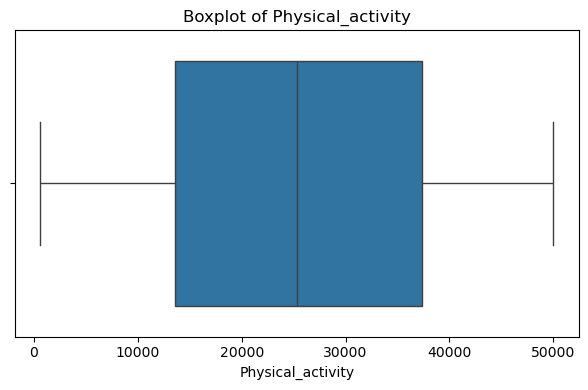

📊 Stats for Physical_activity:
  Q1 (25%): 13605.75
  Q3 (75%): 37382.25
  IQR (Q3 - Q1): 23776.50
  Lower Bound (Q1 - 1.5*IQR): -22059.00
  Upper Bound (Q3 + 1.5*IQR): 73047.00
  Outliers: 0 rows


In [34]:
def show_boxplot_with_stats(data, column):
    # Boxplot 그리기
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()
    
    # 범위 통계 출력
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f"📊 Stats for {column}:")
    print(f"  Q1 (25%): {q1:.2f}")
    print(f"  Q3 (75%): {q3:.2f}")
    print(f"  IQR (Q3 - Q1): {iqr:.2f}")
    print(f"  Lower Bound (Q1 - 1.5*IQR): {lower_bound:.2f}")
    print(f"  Upper Bound (Q3 + 1.5*IQR): {upper_bound:.2f}")
    print(f"  Outliers: {((data[column] < lower_bound) | (data[column] > upper_bound)).sum()} rows")

# 사용 예시
show_boxplot_with_stats(data, 'Physical_activity')

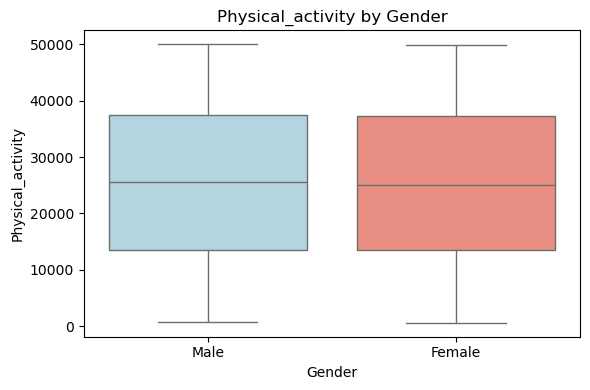

In [38]:
# 성별 라벨 변환 (선택)
data['Sex_label'] = data['Sex'].map({0: 'Female', 1: 'Male'})

# Boxplot 그리기
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x='Sex_label', y='Physical_activity', hue='Sex_label', palette=['lightblue', 'salmon'], legend=False)

plt.title('Physical_activity by Gender')
plt.xlabel('Gender')
plt.ylabel('Physical_activity')
plt.tight_layout()
plt.show()

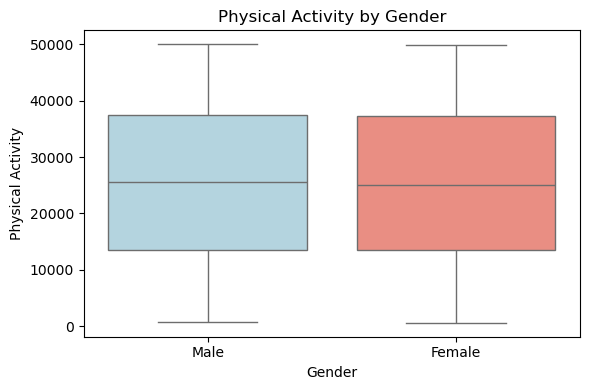

In [40]:
# 성별 라벨 변환 (선택)
data['Sex_label'] = data['Sex'].map({0: 'Female', 1: 'Male'})

# Violinplot 그리기
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x='Sex_label', y='Physical_activity', hue='Sex_label', palette=['lightblue', 'salmon'], legend=False)

plt.title('Physical Activity by Gender')
plt.xlabel('Gender')
plt.ylabel('Physical Activity')
plt.tight_layout()
plt.show()

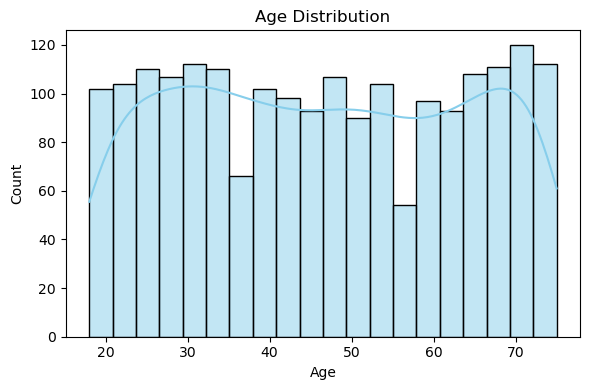

In [42]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='Age', bins=20, kde=True, color='skyblue')  # bins=구간 수, kde=밀도곡선 표시

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

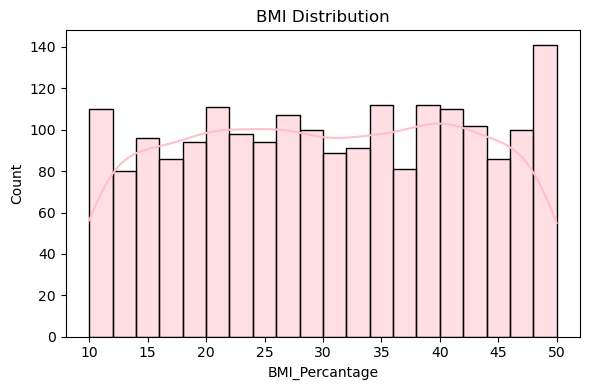

In [44]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='BMI', bins=20, kde=True, color='pink')  # bins=구간 수, kde=밀도곡선 표시

plt.title('BMI Distribution')
plt.xlabel('BMI_Percantage')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

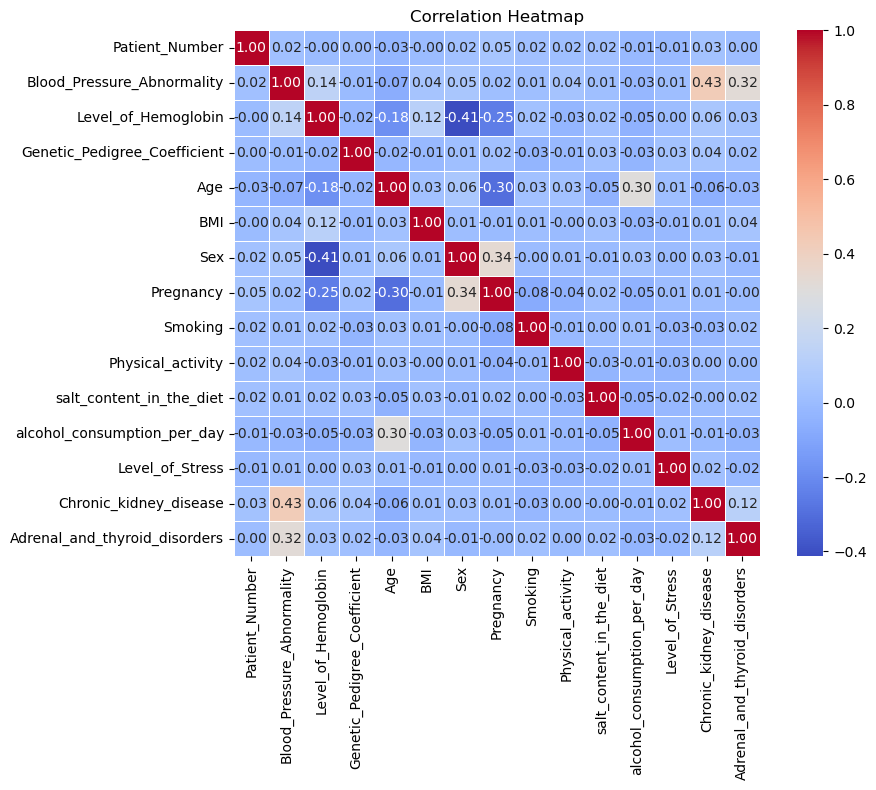

In [46]:
# 수치형 변수만 추출해서 상관관계 행렬 계산
corr = data.corr(numeric_only=True)

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)

plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

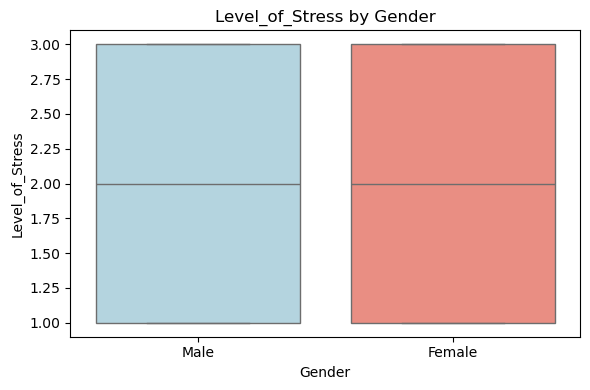

In [50]:
# 성별 라벨 변환 (선택)
data['Sex_label'] = data['Sex'].map({0: 'Female', 1: 'Male'})

# Boxplot 그리기
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=data,
    x='Sex_label',
    y='Level_of_Stress',
    hue='Sex_label',  # 색상 기준 지정
    palette=['lightblue', 'salmon'],
    legend=False      # 범례 생략
)

plt.title('Level_of_Stress by Gender')
plt.xlabel('Gender')
plt.ylabel('Level_of_Stress')
plt.tight_layout()
plt.show()

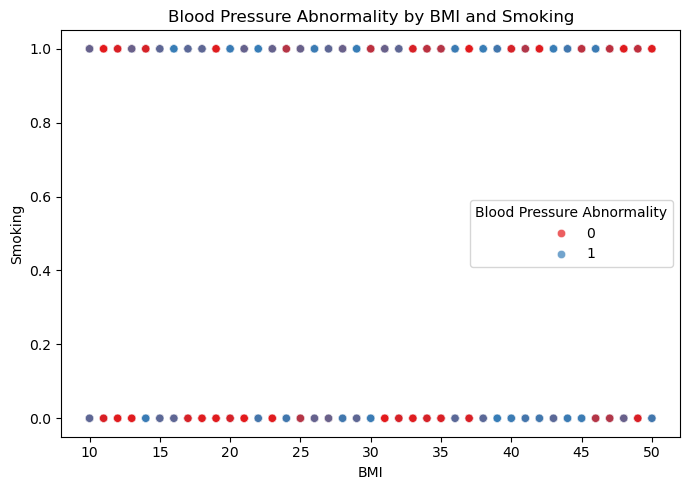

In [86]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='BMI',
    y='Smoking',
    hue='Blood_Pressure_Abnormality',
    palette='Set1',
    alpha=0.7
)

plt.title('Blood Pressure Abnormality by BMI and Smoking')
plt.xlabel('BMI')
plt.ylabel('Smoking')
plt.legend(title='Blood Pressure Abnormality')
plt.tight_layout()
plt.show()

In [56]:
X

array([[11.28,  0.9 , 34.  , ...,  2.  ,  1.  ,  1.  ],
       [ 9.75,  0.23, 54.  , ...,  3.  ,  0.  ,  0.  ],
       [10.79,  0.91, 70.  , ...,  2.  ,  1.  ,  0.  ],
       ...,
       [16.91,  0.22, 18.  , ...,  2.  ,  1.  ,  1.  ],
       [11.15,  0.72, 46.  , ...,  3.  ,  0.  ,  1.  ],
       [11.36,  0.09, 41.  , ...,  1.  ,  1.  ,  0.  ]])

In [58]:
y

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [60]:
# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 훈련 데이터, 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 13), (400, 13), (1600,), (400,))

In [64]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [66]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 입력값, 정답값 하나로 묶기
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 13]),
 torch.Size([400, 13]),
 torch.Size([1600]),
 torch.Size([400]))

In [70]:
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 64)     # 입력특성: 15개, 노드수: 64개
        self.fc2 = nn.Linear(64, 32)    # 노드수: 64 -> 32
        self.fc3 = nn.Linear(32, 2)  # 노드수: 32 -> 2(클래스 개수)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesClassifier()

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [76]:
#학습 중 손실값과 정확도 저장할 리스트
train_losses = []
test_accuracies = []

# 학습 반복 횟수 설정 (에폭 수)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련용 데이터를 32개씩 나누어 학습
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()         # 매번 기울기 초기화
        outputs = model(inputs)       # 예측값 계산 (순전파)
        loss = criterion(outputs, labels)  # 예측값과 정답 비교해서 손실 계산
        loss.backward()               # 역전파: 손실을 기준으로 기울기 계산
        optimizer.step()              # 계산된 기울기로 가중치 업데이트

        running_loss += loss.item()   # 손실 누적

    # 한 에폭당 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # 테스트 데이터로 성능 평가
    model.eval()      # 평가 모드 전환
    correct = 0
    total = 0
    with torch.no_grad():  # 평가할 땐 기울기 계산 X (속도 ↑)
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # 예측 확률이 가장 높은 클래스 선택
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 정확도 계산 (올바르게 예측한 수 / 전체 수)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # 에폭별 결과 출력
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6617, Accuracy: 68.75%
Epoch 2/20, Loss: 0.5656, Accuracy: 71.75%
Epoch 3/20, Loss: 0.5213, Accuracy: 74.75%
Epoch 4/20, Loss: 0.4963, Accuracy: 77.00%
Epoch 5/20, Loss: 0.4716, Accuracy: 79.25%
Epoch 6/20, Loss: 0.4466, Accuracy: 80.75%
Epoch 7/20, Loss: 0.4173, Accuracy: 82.00%
Epoch 8/20, Loss: 0.3915, Accuracy: 82.50%
Epoch 9/20, Loss: 0.3669, Accuracy: 85.50%
Epoch 10/20, Loss: 0.3486, Accuracy: 86.50%
Epoch 11/20, Loss: 0.3331, Accuracy: 84.50%
Epoch 12/20, Loss: 0.3234, Accuracy: 84.75%
Epoch 13/20, Loss: 0.3177, Accuracy: 86.00%
Epoch 14/20, Loss: 0.3162, Accuracy: 84.00%
Epoch 15/20, Loss: 0.3031, Accuracy: 85.75%
Epoch 16/20, Loss: 0.3004, Accuracy: 85.75%
Epoch 17/20, Loss: 0.2943, Accuracy: 85.50%
Epoch 18/20, Loss: 0.2875, Accuracy: 85.75%
Epoch 19/20, Loss: 0.2859, Accuracy: 85.00%
Epoch 20/20, Loss: 0.2852, Accuracy: 85.25%
Training complete.


In [78]:
with torch.no_grad():
    outputs = model(X_test)
    predicted = outputs.argmax(dim=1)  # 클래스 인덱스 (0 or 1)

    correct = (predicted == y_test.squeeze()).sum()
    accuracy = correct / y_test.size(0)

    print(f'\nTest Accuracy: {accuracy:.4f}\n')

    # Confusion matrix 및 메트릭 계산
    y_true = y_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print("Confusion Matrix:")
    print(cm)
    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')


Test Accuracy: 0.8525

Confusion Matrix:
[[172  36]
 [ 23 169]]
F1 Score: 0.85
Precision: 0.82
Recall: 0.88


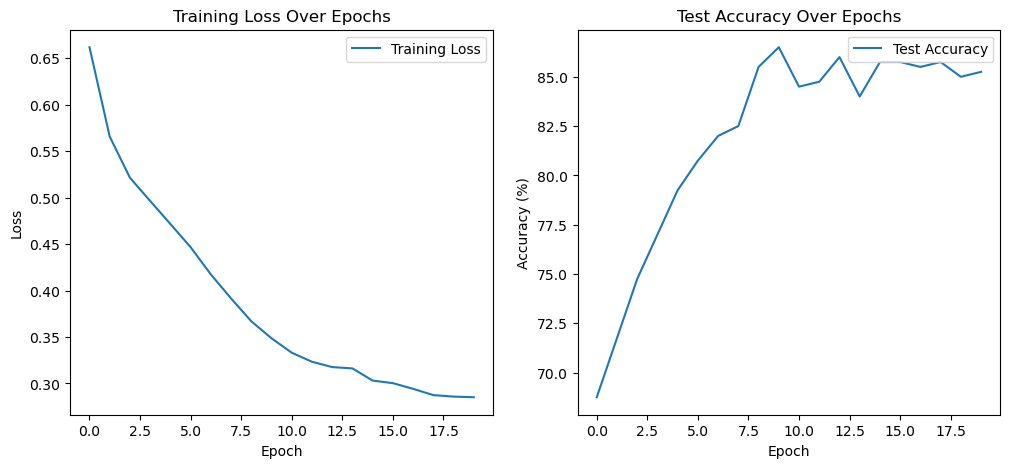

In [82]:
# 에폭(epoch)에 따른 손실과 정확도 시각화
plt.figure(figsize=(12, 5))  # 전체 그래프 크기 지정

# 왼쪽 그래프: 손실 변화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 오른쪽 그래프: 정확도 변화
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()